# Steinmetz dataset

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

In [2]:
fname = []
for j in range(1, 4):
      fname.append(r'C:\Users\josec\Desktop\NMA_group_project\steinmetz_data\steinmetz_part{}.npz'.format(j))

#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(1, len(fname)+1):
      alldat = np.hstack((alldat, np.load(r'C:\Users\josec\Desktop\NMA_group_project\steinmetz_data\steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


## Select Animal 

In [116]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11] # mouse ID
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [117]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Regrouping the data into areas


In [119]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
      barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

# Pupil dynamics

## General pupil dynamics during trials?

In [120]:
# When the responses were positive
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
feedback_type = dat['feedback_type'] # +1 reward, -1 white noise

# Pupil area, 
dat['pupil'][0].shape

(340, 250)

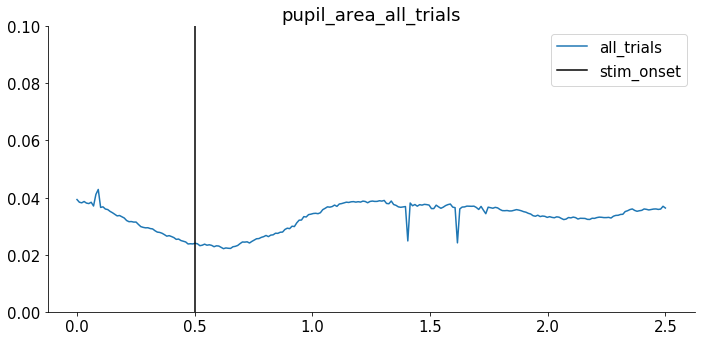

In [122]:
fig, ax = plt.subplots(figsize=(10, 5))

# Tracking of the area
dat['pupil'][0].shape

# First Trial
ax.set_title('pupil_area_all_trials')
ax.plot(np.linspace(0, 2.5, 250), dat['pupil'][0].mean(axis=0), label='all_trials');
ax.axvline(0.5, label='stim_onset', color='black')

ax.set(ylim=(0, 0.10))
ax.legend()

## Pupil area and feedback type:  reward vs white noise 

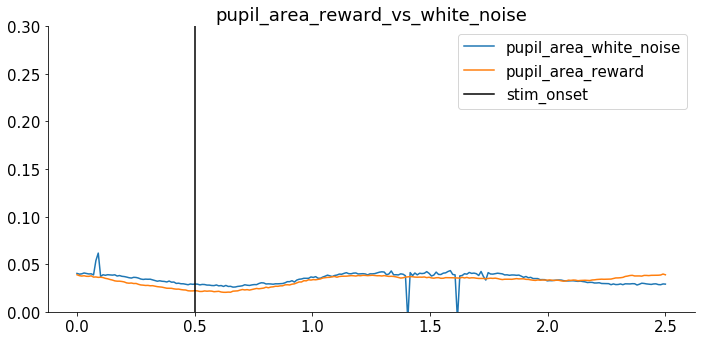

In [123]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title('pupil_area_reward_vs_white_noise')

ax.plot(np.linspace(0, 2.5, 250),
        dat['pupil'][0][feedback_type==-1].mean(axis=0),
        label='pupil_area_white_noise',
       );

ax.plot(np.linspace(0, 2.5, 250),
        dat['pupil'][0][feedback_type==1].mean(axis=0),
        label='pupil_area_reward',
       );

ax.axvline(0.5,
           label='stim_onset',
           color='black',
          )
ax.set(ylim=(0, 0.30))
ax.legend()

## Pupil area: Action dependent pupil dynamics

If the animal turns right vs left vs nogo

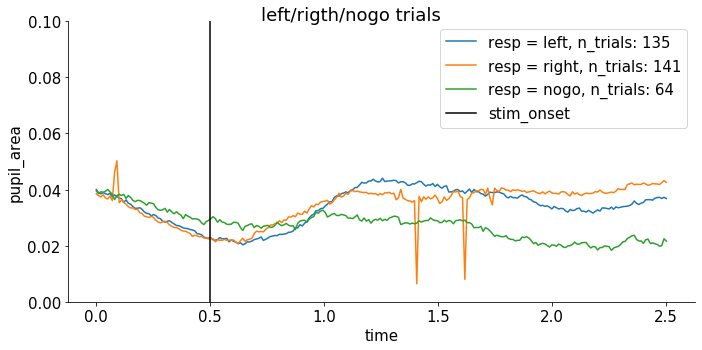

In [125]:

fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('left/rigth/nogo trials')
# Number of left trials
n_left = dat['pupil'][0][response>0].shape[0]
ax.plot(np.linspace(0, 2.5, 250),
        dat['pupil'][0][response>0].mean(axis=0),
        label=f'resp = left, n_trials: {n_left}')

# Number of rigth trials
n_right = dat['pupil'][0][response<0].shape[0]
ax.plot(np.linspace(0, 2.5, 250),
        dat['pupil'][0][response<0].mean(axis=0),
        label=f'resp = right, n_trials: {n_right}')

# # Number of nogo trials
n_none = dat['pupil'][0][response==0].shape[0]
ax.plot(np.linspace(0, 2.5, 250),
        dat['pupil'][0][response==0].mean(axis=0),
        label=f'resp = nogo, n_trials: {n_none}')

    
ax.set(ylabel='pupil_area', xlabel='time')
    
ax.axvline(0.5,
           label='stim_onset',
           color='black',
          )
ax.set(ylim=(0, 0.10))
ax.legend()

### What are the pupil dynamics in trials with reward vs no reward? 

* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  


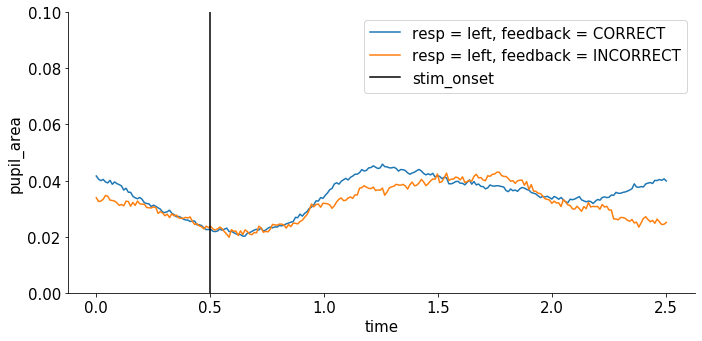

In [126]:
feedback = dat['feedback_type']

fig, ax = plt.subplots(figsize=(10, 5))


# Left Trials
ax.plot(np.linspace(0, 2.5, 250), 
        dat['pupil'][0][np.logical_and(feedback==1, response>0)].mean(axis=0),
        label='resp = left, feedback = CORRECT')
ax.plot(np.linspace(0, 2.5, 250), 
        dat['pupil'][0][np.logical_and(feedback==-1, response>0)].mean(axis=0),
        label='resp = left, feedback = INCORRECT')
    

#############
ax.set(ylabel='pupil_area', xlabel='time', ylim=(0, 10))
ax.axvline(0.5,
           label='stim_onset',
           color='black',
          )
ax.set(ylim=(0, 0.10))
ax.legend()

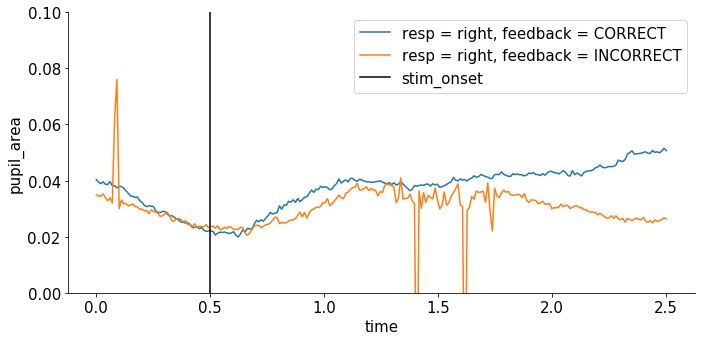

In [127]:
feedback = dat['feedback_type']

fig, ax = plt.subplots(figsize=(10, 5))


# Right Trials
ax.plot(np.linspace(0, 2.5, 250), 
        dat['pupil'][0][np.logical_and(feedback==1, response<0)].mean(axis=0),
        label='resp = right, feedback = CORRECT')
ax.plot(np.linspace(0, 2.5, 250), 
        dat['pupil'][0][np.logical_and(feedback==-1, response<0)].mean(axis=0),
        label='resp = right, feedback = INCORRECT')
    

#############
ax.set(ylabel='pupil_area', xlabel='time', ylim=(0, 10))
ax.axvline(0.5,
           label='stim_onset',
           color='black',
          )
ax.set(ylim=(0, 0.10))
ax.legend()

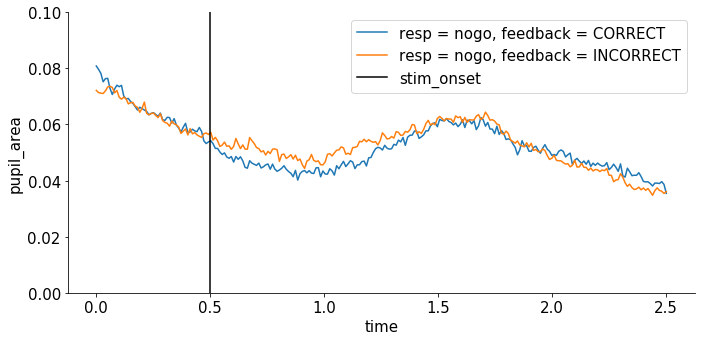

In [75]:
feedback = dat['feedback_type']

fig, ax = plt.subplots(figsize=(10, 5))


# Right Trials

ax.plot(np.linspace(0, 2.5, 250), 
        dat['pupil'][0][np.logical_and(feedback==1, response==0)].mean(axis=0),
        label='resp = nogo, feedback = CORRECT')
ax.plot(np.linspace(0, 2.5, 250), 
        dat['pupil'][0][np.logical_and(feedback==-1, response==0)].mean(axis=0),
        label='resp = nogo, feedback = INCORRECT')
    

#############
ax.set(ylabel='pupil_area', xlabel='time', ylim=(0, 10))
ax.axvline(0.5,
           label='stim_onset',
           color='black',
          )
ax.set(ylim=(0, 0.10))
ax.legend()